In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from plotting_funcs import plot_all_conditions, plot_condition_classes
from sklearn.linear_model import LinearRegression



In [3]:
path = './data'
txt_files = sorted(list_files_with_extension(path, '.txt'))

# Add a 'time_index' column before concatenating all_X
all_X = []

for i, file in enumerate(txt_files):
    file_idx = i
    file_name = file.split('_')[-1]
    condition = file_name.split(' ')[-1].replace('.txt', '')
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['file_idx'] = file_idx
    X_local['file_name'] = file_name
    X_local['condition'] = condition    
    all_X.append(X_local)
    print(i, ':', file_name, "condition:", condition)

all_X = pd.concat(all_X, ignore_index=True)


0 : Manual Calibration Full Setup run 1 bath 50.txt condition: 50


In [5]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

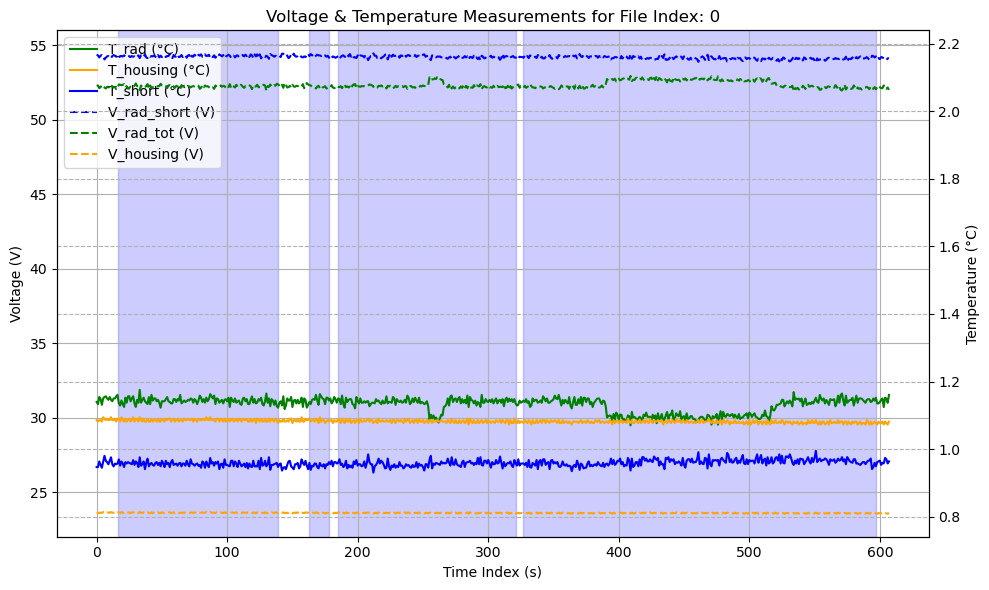

In [6]:
all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
all_X["T_rad"] = T_rad_func(all_X["V_rad_tot"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
all_X["T_short"] = T_rad_func(all_X["V_rad_short"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)



variables_right = ['V_rad_short', 'V_rad_tot', 'V_housing',]
variables_left = ['T_rad', 'T_housing', 'T_short']
y_axes_right_lims = (None, None)
y_axes_left_lims = (22, 56)

variables_colors = {
    'V_rad_short': 'blue',
    'V_rad_tot': 'green',
    'V_housing': 'orange',
    'V_diode': 'red',
    'V_spike': 'purple',
    'T_housing': 'orange',
    'T_rad': 'green',
    'T_short': 'blue',
    'T_antenna': 'purple'
}
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)',
    'T_housing': 'T_housing (°C)',
    'T_rad': 'T_rad (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_short': 'T_short (°C)'
}

for idx in all_X['file_idx'].unique():
    subset = all_X[all_X['file_idx'] == idx]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    for var in variables_left:
        ax1.plot(subset.time_index, subset[var] , label=labels[var], color=variables_colors[var])
    ax1.set_xlabel("Time Index (s)")
    ax1.set_ylabel("Voltage (V)")
    ax1.grid(True)
    ax1.set_ylim(y_axes_left_lims)

    ax2 = ax1.twinx()
    for var in variables_right:
        ax2.plot(subset.time_index, subset[var] / 1000, label=labels[var], linestyle='--', color=variables_colors[var])
    ax2.set_ylabel("Temperature (°C)")
    ax2.grid(True, linestyle='--')
    ax2.set_ylim(y_axes_right_lims)

    # Cooling periods shading
    cooling_periods = subset[subset['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            ax1.axvspan(start, end, color='blue', alpha=0.2)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f"Voltage & Temperature Measurements for File Index: {idx}")
    plt.tight_layout()
    plt.show()

In [7]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = []
    labels_50 = ["antenna", "*", "**", "antenna+cooling"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())


Valid classes by condition:

Condition: 50
class
antenna+cooling    271
antenna            124
Name: count, dtype: int64



Condition 50 - Data summary by class:
  antenna: 124 points, time range: 0.0 - 123.0 s
  antenna+cooling: 271 points, time range: 144.0 - 414.0 s


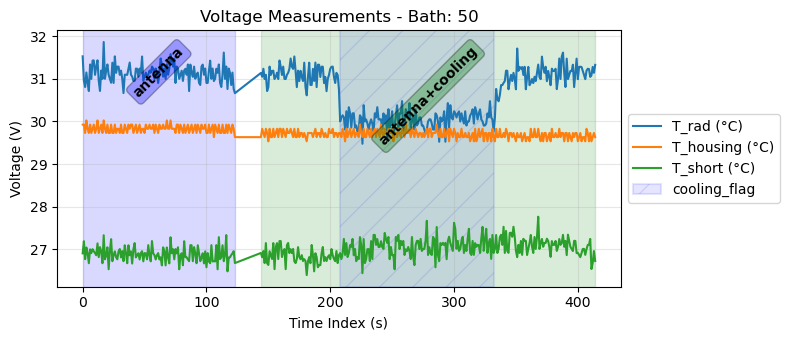

In [9]:
class_order = ["antenna", "antenna+cooling"]
class_colors = {
    'antenna': 'blue',
    'antenna+cooling': 'green'
}
variables = ['T_rad', 'T_housing', 'T_short']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)


Condition 50 - Data summary by class:
  antenna: 124 points, time range: 0.0 - 123.0 s
  antenna+cooling: 271 points, time range: 144.0 - 414.0 s


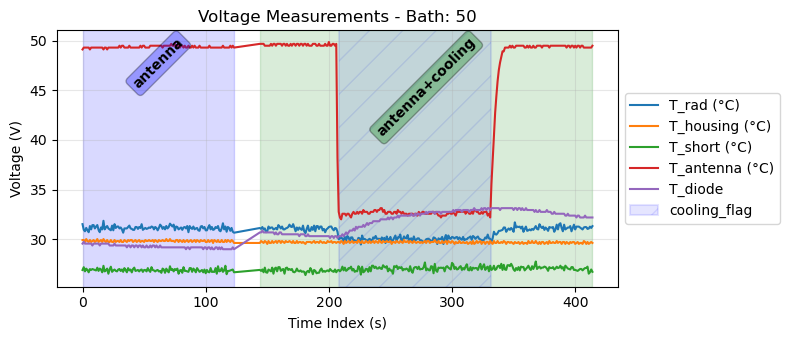

In [12]:
AntennaSlope = 187.904012
AntennaOffset = 0.628991

all_X_clean["T_antenna"] = T_housing_func(all_X_clean["V_spike"]/1000, AntennaSlope, AntennaOffset)
all_X_clean["T_diode"] = T_housing_func(all_X_clean["V_diode"]/1000, AntennaSlope, AntennaOffset)

class_order = ["antenna", "antenna+cooling"]
class_colors = {
    'antenna': 'blue',
    'antenna+cooling': 'green'
}
variables = ['T_rad', 'T_housing', 'T_short', 'T_antenna', 'T_diode']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)


In [17]:
slope_tau_t = -0.00196
intercept_tau_t = 0.366

for i, r in all_X_clean.iterrows():
    tau_tot, T_tot = solve_tau_pre_diode_T_pre_diode(
        r["T_short"],
        r["T_housing"],
        slope_tau_t,
        intercept_tau_t
    )
    if T_tot is None: 
        print(f"Row {i}: T_tot is None")
        all_X_clean.loc[i, "T_end_of_cable"] = None
    else:
        all_X_clean.loc[i, "tau_T_calc"] = tau_tot
        all_X_clean.loc[i, "T_total_calc"] = T_tot
        T_end_of_cable = T_tissue_cable_func(
            r["T_rad"],
            T_tot,
            tau_tot
        )
        all_X_clean.loc[i, "T_end_of_cable"] = T_end_of_cable

In [19]:
tau_h = 0.6424308991704384
tau_a = 0.6720461700531027

In [27]:
def T_tissue_with_handle(T_eoc, T_handle, T_antenna, tau_handle, tau_antenna):
    # return (T_eoc - T_bath*tau_antenna*tau_handle - T_antenna*tau_handle*(1 - tau_antenna)) / (1 - tau_handle)
    return (T_eoc - T_antenna*tau_handle*(1 - tau_antenna) - T_handle*(1-tau_handle)) / (tau_antenna*tau_handle)

In [30]:
all_X_clean["T_bath_cal"] = all_X_clean.apply(lambda row: T_tissue_with_handle(
    row["T_end_of_cable"],
    26,
    row["T_antenna"],
    tau_h,
    tau_a,
), axis=1)


Condition 50 - Data summary by class:
  antenna: 124 points, time range: 0.0 - 123.0 s
  antenna+cooling: 271 points, time range: 144.0 - 414.0 s


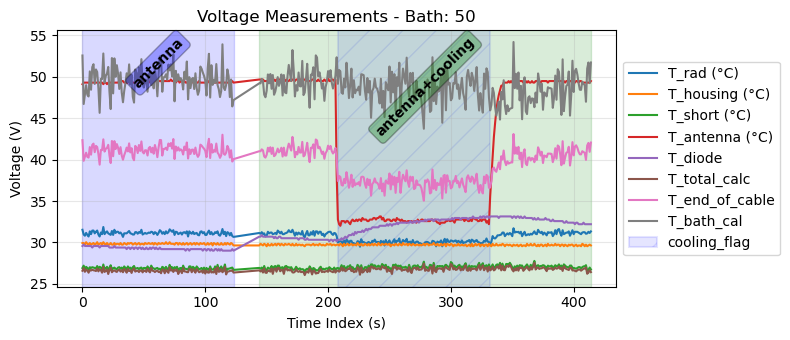

In [31]:
class_order = ["antenna", "antenna+cooling"]
class_colors = {
    'antenna': 'blue',
    'antenna+cooling': 'green'
}
variables = ['T_rad', 'T_housing', 'T_short', 'T_antenna', 'T_diode', 'T_total_calc', 'T_end_of_cable', 'T_bath_cal']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

In [33]:
0.3*0.3


0.09